# Imports

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math


# Helper functions

In [4]:
def convert_bytes(size_in_bits):
    # Converts size in bits to a human-readable format (Bytes, KB, MB, GB)
    size_in_bytes = size_in_bits / 8
    if size_in_bytes < 1024:
        return f"{size_in_bytes} Bytes"
    elif size_in_bytes < 1024**2:
        return f"{size_in_bytes / 1024:.2f} KB"
    elif size_in_bytes < 1024**3:
        return f"{size_in_bytes / 1024**2:.2f} MB"
    else:
        return f"{size_in_bytes / 1024**3:.2f} GB"

def file_to_bits(file_path):
    # Reads a file and converts its content to a bit stream
    with open(file_path, "rb") as file:
        byte_data = file.read()  
    bit_stream = ''.join(format(byte, '08b') for byte in byte_data)  # Convert to bits
    return bit_stream

def optimal_n_finder(original_img_num_bits, data_add_num_bits, metadata_bits=48):
    # Calculates the optimal n (q) based on the size of the original image and additional data
    # Takes into account that not the whole image is available, but that a part is reserved for metadata
    n_opt = (8 * data_add_num_bits) / (original_img_num_bits - (metadata_bits/4) * 8)

    if data_add_num_bits <= 0 or original_img_num_bits <= 0:
        return None

    if n_opt > 4 and n_opt < 8:
        print("TREBA UPSCALEat x2")
        return -2  # Optional: Suggest upscaling or give warning

    if n_opt >= 8 or n_opt <= 0:
        return None
    else:
        return n_opt
    
def possible_n(old_n, bits=12): 
    # Not all n values are posible to save exactly, so to ensure we encode/decode with exactly same n, we introduce this wrapper function
    max_scaled = 2 ** bits
    if old_n>=8:
        print(f"Error: n has to be lower than 8!")
        print(f"Will autocast n to 7.9")
    old_n = min(old_n, 7.9)
    n_scale_real = (old_n * (max_scaled/8) )  
    n_scale_real_round = math.ceil(n_scale_real)
    new_n = n_scale_real_round * (8/max_scaled) 
    # treba voditi i racuna da je u range [0, 8>
    return new_n

def n_to_bits(n, bits = 12):
    max_scaled = 2 ** bits
    if n>=8:
        print(f"Error: n has to be lower than 8!")
        print(f"Will autocast n to 7.9")
    n = min(n, 7.9)
    n_scale_real = (n * (max_scaled/8) )  
    n_scale_real_round = math.ceil(n_scale_real)
    
    return format(n_scale_real_round, f'0{bits}b') 

def bits_to_n(stream_b, bits = 12):
    max_scaled = 2 ** bits
    if len(stream_b) != bits:
        print(f"Error: stream of bits has size {len(stream_b)} but {bits} is expected!")
        return None
    n_scale_real = int(stream_b, 2)
    
    n = (n_scale_real * (8/max_scaled) )
    return n


def bits_to_integer(bit_stream):
    if not all(bit in '01' for bit in bit_stream):
        raise ValueError("Input must be a string of bits (only '0' and '1') -> recieved:", bit_stream)
    
    return int(bit_stream, 2)


def integer_to_bits(number, num_bits):
    if number < 0:
        raise ValueError("Only non-negative integers are supported.")
    if number >= 2 ** num_bits:
        raise ValueError(f"Number {number} cannot be represented in {num_bits} bits.")
    
    return format(number, f'0{num_bits}b')

# podrzane ekstenzije za dodatne podatke
EXTENSION_MAP = {
    '.txt':  '0000',
    '.png':  '0001',
    '.jpg':  '0010',
    '.jpeg': '0011',
    '.pdf':  '0100',
    '.csv':  '0101',
    '.json': '0110',
    '.mp3':  '0111',
    '.wav':  '1000',
    '.zip':  '1001',
    '.mp4':  '1010',
    '.docx': '1011',
    '.xlsx': '1100',
    '.pptx': '1101',
    '.bin':  '1110',
    '.log':  '1111',
}

def is_supported_extension(ext):
    return ext.lower() in EXTENSION_MAP

def encode_extension(ext):
    ext = ext.lower()
    if ext not in EXTENSION_MAP:
        raise ValueError(f"Unsupported extension: {ext}")
    return EXTENSION_MAP[ext]

def decode_extension(bits):
    if len(bits) != 4 or not all(b in '01' for b in bits):
        raise ValueError("Extension bits must be a 4-bit binary string.")
    
    inv_map = {v: k for k, v in EXTENSION_MAP.items()}
    if bits not in inv_map:
        raise ValueError(f"Unknown 4-bit extension code: {bits}")
    return inv_map[bits]


def bitstream_to_file(bitstream, extension, output_path='recovered_file'):
    # Rekonstruira additional file iz bitstreama
    # Odmah sprema u memoriju

    # Validate the extension
    EXTENSION_MAP = {
        '.txt':  '0000',
        '.png':  '0001',
        '.jpg':  '0010',
        '.jpeg': '0011',
        '.pdf':  '0100',
        '.csv':  '0101',
        '.json': '0110',
        '.mp3':  '0111',
        '.wav':  '1000',
        '.zip':  '1001',
        '.mp4':  '1010',
        '.docx': '1011',
        '.xlsx': '1100',
        '.pptx': '1101',
        '.bin':  '1110',
        '.log':  '1111',
    }

    if extension not in EXTENSION_MAP:
        raise ValueError(f"Unsupported extension '{extension}'. Supported: {list(EXTENSION_MAP.keys())}")

    # Make sure bitstream length is a multiple of 8
    if len(bitstream) % 8 != 0:
        bitstream = bitstream[:len(bitstream) - (len(bitstream) % 8)]

    # Convert bitstream to bytes
    byte_data = bytes(int(bitstream[i:i+8], 2) for i in range(0, len(bitstream), 8))

    # Save to file
    full_path = output_path + extension
    with open(full_path, 'wb') as f:
        f.write(byte_data)
    
    print(f"Recovered file saved at: {full_path}")

    return full_path

# Quantization Demonstration

The following code is just a demonstration of different quantization levels with and without noise.

The `quantize_img` function returns a quantized image. It takes in an image of shape `(height, width, channels)`, and a quantization factor `q`.
This function is not used in the final encoder, because the quantization happens dynamically, based on the size of the data.


In [5]:
def quantize_img(orig_img, q = 4):
    new_image = np.zeros(orig_img.shape, dtype=np.uint8)

    for h in range(0, orig_img.shape[0]):
        for w in range(0, orig_img.shape[1]):
            
            for cc in range(0, orig_img.shape[2]):
                new_image[h][w][cc] = orig_img[h][w][cc] - (orig_img[h][w][cc]  % q)
    
    return new_image

def quantize_rand_noise_img(orig_img, q = 4): 
    new_image = np.zeros(orig_img.shape, dtype=np.uint8)

    for h in range(0, orig_img.shape[0]):
        for w in range(0, orig_img.shape[1]):
            
            for cc in range(0, orig_img.shape[2]):
                new_image[h][w][cc] = orig_img[h][w][cc] - (orig_img[h][w][cc]  % q)
                new_image[h][w][cc] += np.random.randint(0,q)
    
    return new_image
    

In [9]:
q = 4

# Input image path - original image into which additional data will be added
orig_img = "data/orig_img.png"

# Additional file path - additional data; It will be converted to bits and embedded into the quantized original image
add_data = "data/additional_data.txt"

print("INPUT IMAGE:")
in_img = cv2.imread(orig_img)
orig_img_shape = in_img.shape
print("------------------")
print(f"size - {convert_bytes(os.path.getsize(orig_img))}")
print(f"shape - {in_img.shape}")

print("\n\nADDITIONAL DATA:")
print("------------------")
print(f"size - {convert_bytes(os.path.getsize(add_data))}")
print(f"type - {os.path.splitext(add_data)[1] }")

INPUT IMAGE:
------------------
size - 17.80 KB
shape - (300, 613, 3)


ADDITIONAL DATA:
------------------
size - 5.125 Bytes
type - .txt


The following code block performs quantization for several quantization levels.

q = 2


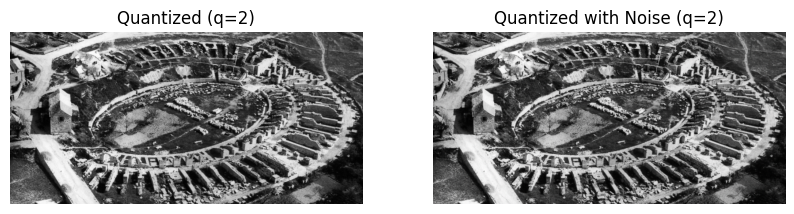

q = 4


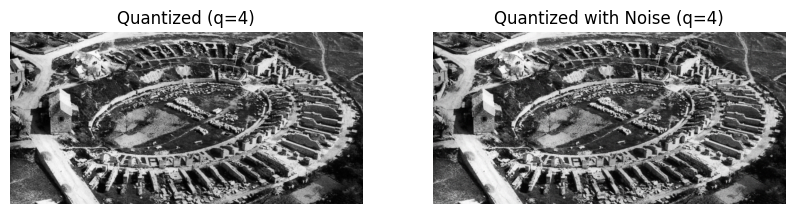

q = 8


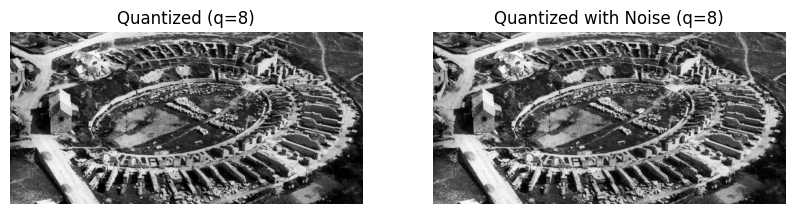

q = 16


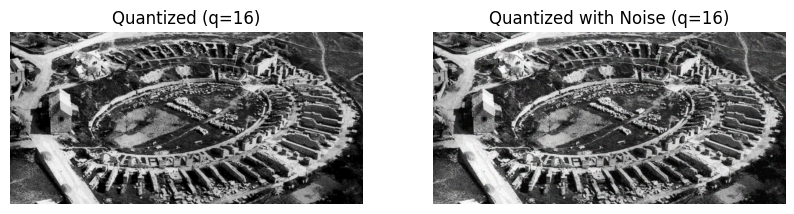

q = 32


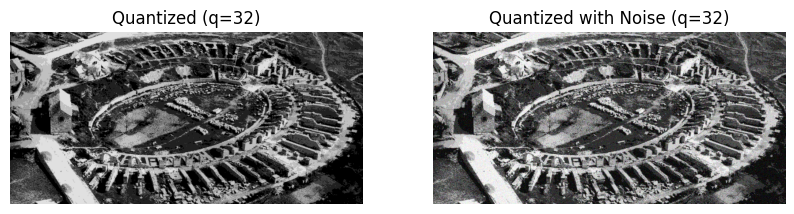

q = 64


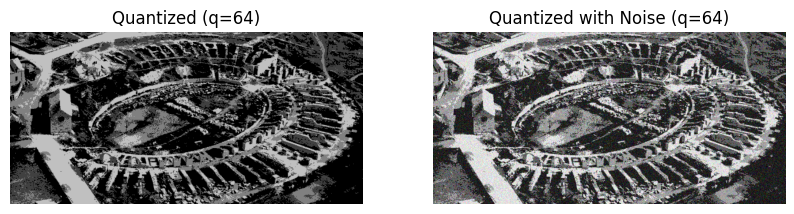

q = 128


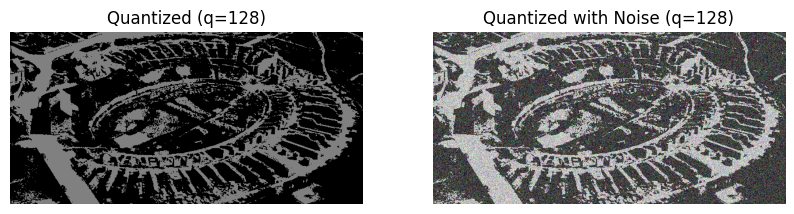

In [12]:
for kv in [2, 4, 8, 16, 32, 64, 128]:
    kv_img = quantize_img(in_img, q = kv)
    print("q =", kv)
    kvnoise_img = quantize_rand_noise_img(in_img, q = kv)


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot quantized image
    axes[0].imshow(cv2.cvtColor(kv_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Quantized (q={kv})")
    axes[0].axis('off')  # Hide axes for better visualization
    
    # Plot quantized image with noise
    axes[1].imshow(cv2.cvtColor(kvnoise_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Quantized with Noise (q={kv})")
    axes[1].axis('off')  # Hide axes for better visualization
    
    plt.show()

# Encoding

First, we need to load the image and the data for encoding.

In [13]:
orig_img_path = "data/orig_img.png"
add_data_path = "data/additional_data.txt"

print("INPUT IMAGE:")
orig_img = cv2.imread(orig_img_path)
orig_img_shape = orig_img.shape
print("------------------")
#print(f"size - {convert_bytes(os.path.getsize(in_im_path))}")
print(f"shape - {orig_img.shape}")
print("bits -", convert_bytes(orig_img.shape[0] * orig_img.shape[1] * orig_img.shape[2] * 8))

print("\n\nADDITIONAL DATA:")
print("------------------")
print(f"type - {os.path.splitext(add_data_path)[1] }")
print("bits -", convert_bytes(len(file_to_bits(add_data_path))))

INPUT IMAGE:
------------------
shape - (300, 613, 3)
bits - 538.77 KB


ADDITIONAL DATA:
------------------
type - .txt
bits - 41.0 Bytes


The following code encodes the data into the image.

In [26]:
def encode(original_image, additional_data_path, n=-1, verbose=False):
    """
    Function for encoding additional data into an image using quantization.
    Args:
        original_image (numpy.ndarray): The original image to encode data into.
        additional_data_path (str): Path to the file containing additional data to encode.
        n (int, optional): The number of bits per pixel to use for encoding. If -1, finds optimal n.
        VERBOSE (bool, optional): If True, prints detailed information during encoding.
    """
    in_img = original_image.copy()

    # Check if the file type is supported
    ext = os.path.splitext(additional_data_path)[1] 
    if not is_supported_extension(ext):
        print(f"[!] Unsupported extension: {ext}")
        print("Supported extensions are:", ', '.join(sorted(EXTENSION_MAP.keys())))
        return None

    data_mask_img = np.zeros(in_img.shape, dtype=np.uint8)  # 24 bits per pixel -> first 4 pixels are to store metadata (n_opt)
    bit_stream = file_to_bits(additional_data_path)

    if n == -1:  # nađi optimalni n_opt_poss

        orig_img_shape = original_image.shape
        if len(orig_img_shape) == 3:
            original_img_num_bits = orig_img_shape[0] * orig_img_shape[1] * orig_img_shape[2] * 8
        else:  # for b/w photos
            original_img_num_bits = orig_img_shape[0] * orig_img_shape[1] * 8

        n_opt = optimal_n_finder(original_img_num_bits, len(bit_stream))
        if n_opt == -2:
            # upscale x2 image and work with that
            print("[!] Not enough space. Automatically upscaling the image by 2x...")


            upscaled_img = cv2.resize(orig_img, (orig_img.shape[1]*2, orig_img.shape[0]*2), interpolation=cv2.INTER_LINEAR)

            orig_img = upscaled_img  # replace the original
            orig_img_shape = orig_img.shape  # update shape
            original_img_num_bits = orig_img.size * 8  # update bit count

            # Recompute after upscaling
            n_opt = optimal_n_finder(original_img_num_bits, len(bit_stream))
            if n_opt is None:
                raise ValueError("Still not enough space or invalid input after upscaling.")
        
        n_poss = possible_n(n_opt) 

    else:
        n_poss = n

    len_add_data = len(bit_stream)
    
    full_add_data = n_to_bits(n=n_poss, bits=12) + integer_to_bits(len_add_data, num_bits=32) + encode_extension(ext) + bit_stream  # metadata + add_data # MAPIRAJ file type

    n_real = n_poss // 1
    n_decimal = n_poss % 1
    pix_ch_i = -12
    stream_pointer = 0

    if verbose:
        print("llen:", len_add_data)
        print("LEN FULL DATA:", len(full_add_data))
        print("metadata:", n_to_bits(n=n_poss, bits=12))
        print("n_opt_poss:", n_poss, "->", n_real, n_decimal)

        print("-------------")
        print("-------------")
        print()

    for h in range(0, in_img.shape[0]):
        for w in range(0, in_img.shape[1]):
            for cc in range(0, in_img.shape[2]):
                if stream_pointer >= len(full_add_data): # very important, to know when whole data is loaded
                    break

                # zapiši metapodatak (n)
                if pix_ch_i < 0:
                    n_curr = 4
                    q = 2 ** n_curr
                    bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                    stream_pointer += n_curr

                    original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                    data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #
                    if verbose:
                        print("bits_curr:", bits_curr)
                        print("quan_img[h][w][cc]:", original_image[h][w][cc])
                        print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                        print("MMMMMM")
                        print("MMMMMM")
                        print("MMMMMM")
                
                    
                    
                else:
                    # n je decimalan
                    if n_decimal > 0:
                        if verbose:
                            print("HEYYY", n_poss, "----", n_decimal)
                        
                        # poseban pixo-kanal di zapisujemo više info
                        if pix_ch_i % ( math.floor(1 / n_decimal) ) == 0: # ceil ili floor
                            if verbose:
                                print("PoSeBAn")
                            # dodaj math.ceil(n_poss) (zadnja bita)
                            n_curr = math.ceil(n_poss)
                            q = 2 ** n_curr
                            bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                            # IF THERE IS NO ENOUGH LEFT -> add zero to end, BUT encode exact expected length
                            stream_pointer += n_curr
                            original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                            data_mask_img[h][w][cc] = bits_to_integer(bits_curr)
                            
                            if verbose:
                                print("bits_curr:", bits_curr)
                                print("quan_img[h][w][cc]:", original_image[h][w][cc])
                                print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                                print("after[h][w][cc]:", data_mask_img[h][w][cc])
                                print("PPPPPP")
                                print("PPPPPP")
                                print("PPPPPP")

                        # obican piksokanal, obicno upisivanje
                        else: 
                            if verbose:
                                print("OBIcaN")
                            # dodaj math.floor(n_poss) (zadnja bita)
                            n_curr = math.floor(n_poss)
                            q = 2 ** n_curr
                            bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                            # IF THERE IS NO ENOUGH LEFT -> add zero to end, BUT encode exact expected length
                            stream_pointer += n_curr
                            original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                            if n_curr > 0:
                                data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #
                                if verbose:
                                    print("bits_curr:", bits_curr)
                                    print("quan_img[h][w][cc]:", original_image[h][w][cc])
                                    print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                                    print("after[h][w][cc]:", data_mask_img[h][w][cc])
                                    print("OOOOOO")
                                    print("OOOOOO")
                                    print("OOOOOO")

                    # n je prirodan broj
                    else: 
                        if verbose:
                            print("ALOHA", n_poss, "----", n_decimal)
                        # svugdje isto dodaj (possible_n) zadnja bita
                        n_curr = n_poss
                        q = 2 ** n_curr
                        bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                        stream_pointer += n_curr
                        original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                        if n_curr > 0:
                            data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #

    
                if verbose:
                    print("stream_idx:", stream_pointer)
                    print("--pozicija:", h, ",", w, ",", cc)
                    print()
                    
                pix_ch_i += 1


    return original_image + data_mask_img, data_mask_img


In [27]:
processed_img, mask = encode(in_img, add_data_path)

Next, we will display the original image, the mask of the data in the image, and the encoded image.

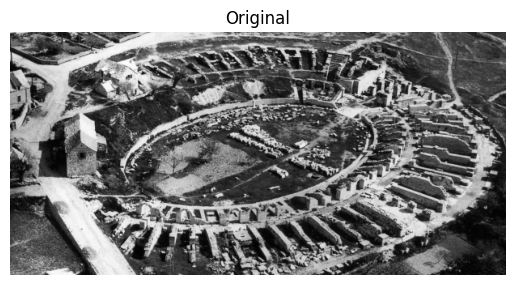

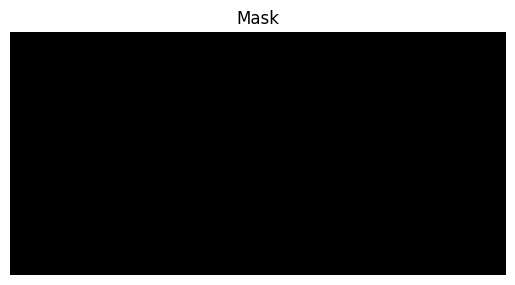

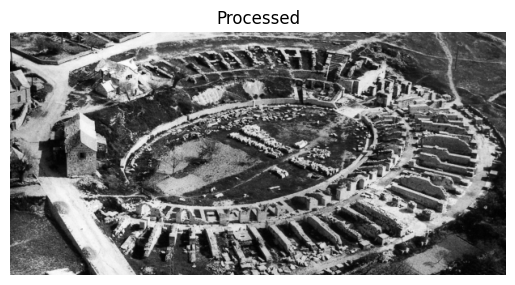

(300, 613, 3)
Images differ.


In [28]:
image_rgb = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original")
plt.axis('off')
plt.show()

image_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Mask")
plt.axis('off')
plt.show()

image_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Processed")
plt.axis('off')
plt.show()

print(processed_img.shape)

are_identical = np.array_equal(in_img, processed_img)

if are_identical:
    print("Images are exactly the same!")
else:
    print("Images differ.")

# Decoding

Decoding of the data is the opposite process than encoding.

In [29]:
def decode(processed_img, verbose=False):
    """
    Function for decoding additional data from an image.
    Args:
        processed_img (numpy.ndarray): The image from which to decode data.
        verbose (bool, optional): If True, prints detailed information during decoding.
    """

    in_img = processed_img.copy()

    metadata_bitstream = ''
    add_data_bitstream = ''
    ext_type = ''
    stream_len = -1
    n_opt_poss = -1
    n_real = -1
    n_decimal = -1
    stream_cnt = 0
    pix_ch_i = -12
    
    for h in range(0, in_img.shape[0]):
        for w in range(0, in_img.shape[1]):
            for cc in range(0, in_img.shape[2]):
                if (stream_len != -1) and (stream_cnt>=stream_len):
                    break

                if pix_ch_i < 0:  # extract metadata
                    n_curr = 4
                    q = 2 ** n_curr
                    excess = processed_img[h][w][cc]  % q
                    metadata_bitstream += integer_to_bits(excess, num_bits=n_curr)
                    processed_img[h][w][cc] = processed_img[h][w][cc] - excess


                
                else:  # extract additional data
                    if pix_ch_i == 0:
                        n_metadata = metadata_bitstream[0:12]
                        len_metadata = metadata_bitstream[12:44]
                        type_metadata = metadata_bitstream[44:]
                        n_opt_poss = bits_to_n(n_metadata, bits = 12)
                        n_real = n_opt_poss // 1
                        n_decimal = n_opt_poss % 1
                        stream_len = bits_to_integer(len_metadata)
                        ext_type = decode_extension(type_metadata)

                        if verbose:
                            print("n_real:", n_real)
                            print("n_decimal:", n_decimal)
                            print("metadata_len:", len(metadata_bitstream))
                            print("stream_len:", stream_len)

                    
                    
                    # n je decimalan
                    if n_decimal > 0:

                        # poseban pixo-kanal di je zapisano više info
                        if pix_ch_i % ( math.floor(1 / n_decimal) ) == 0:
                            n_curr = math.ceil(n_opt_poss)
                            q = 2 ** n_curr
                            excess = processed_img[h][w][cc] % q
                            add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                            processed_img[h][w][cc] = processed_img[h][w][cc] - excess
                            stream_cnt += n_curr


                        # obican piksokanal, obicno upisivanje
                        else: 
                            n_curr = math.floor(n_opt_poss)
                            if n_curr > 0:
                                q = 2 ** n_curr
                                excess = processed_img[h][w][cc] % q
                                add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                                processed_img[h][w][cc] = processed_img[h][w][cc] - excess
                                stream_cnt += n_curr


                    # n je prirodan broj
                    else: 
                        n_curr = n_opt_poss
                        if n_curr > 0:
                            q = 2 ** n_curr
                            excess = processed_img[h][w][cc] % q
                            add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                            processed_img[h][w][cc] = processed_img[h][w][cc] - excess
                            stream_cnt += n_curr


                pix_ch_i += 1

    if len(add_data_bitstream) > stream_len:
        add_data_bitstream = add_data_bitstream[:stream_len]
    
    return processed_img, (add_data_bitstream, ext_type)

In [30]:
original_image_decoded, additional_data_decoded = decode(processed_img)

Next, we will compare the decoded data with the original data that was encoded in the image. Since our encoder/decoder structure is lossless, the bit streams should be exactly the same.

In [31]:
bit_stream = file_to_bits(add_data_path)
if bit_stream == additional_data_decoded[0]:
    print("The streams are exactly the same!")
else:
    print("The streams are different.")

The streams are exactly the same!


We can also save the decoded data.

In [32]:
path = bitstream_to_file(additional_data_decoded[0], additional_data_decoded[1], output_path='data/recovered_file')


Recovered file saved at: recovered_file.txt
